# Imports

In [1]:
PROJECT_DIR = "/Users/pluz999/Documents/Oxford/Thesis/queue-value"

import sys
sys.path.append(PROJECT_DIR)

from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from micro_price.ImbalanceMicroPrice import ImbalanceMicroPrice
from orderbook_aggregator.ImbalanceAggregator import ImbalanceAggregator

# Global variables

In [2]:
ticker = "CSCO"
levels = 5
start_date = datetime(2020,1,2)
end_date = datetime(2020,1,31)

# Load and process order book data

In [3]:
imbalance_microprice = ImbalanceMicroPrice([])
for d in tqdm(pd.date_range(start_date, end_date)):
    try:
        imbalance_orderbook = ImbalanceAggregator(d, ticker, levels, spread_size=100)
        imbalance_microprice.build_from_orderbooks([imbalance_orderbook])
    except FileNotFoundError:
        continue

100%|██████████| 30/30 [08:33<00:00, 17.12s/it]


# Calculate micro-price

In [4]:
micro_price = imbalance_microprice.calculate_micro_price()

# Plot micro-price

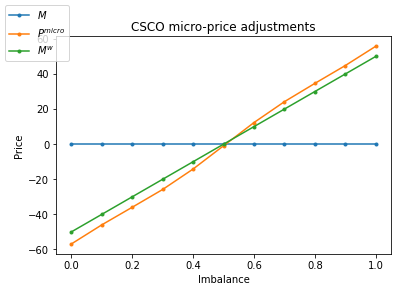

In [5]:
fig, ax = plt.subplots()
ax.plot(micro_price.index, np.repeat(0,len(micro_price.index)), ".-")
ax.plot(micro_price, ".-")
ax.plot(micro_price.index, np.linspace(-50,50,len(micro_price.index)), ".-")
ax.set_xlabel("Imbalance")
ax.set_ylabel("Price")
ax.set_title("CSCO micro-price adjustments")
fig.legend([r"$M$"] + [r"$P^{micro}$"] + [r"$M^{w}$"], loc="upper left")
plt.show()

In [6]:
example_plot = imbalance_orderbook.orderbook.iloc[12000:15000].copy()
example_micro_prices = [micro_price.loc[imbalance] for imbalance in example_plot["imbalance"]]
example_plot["micro_price"] = example_micro_prices

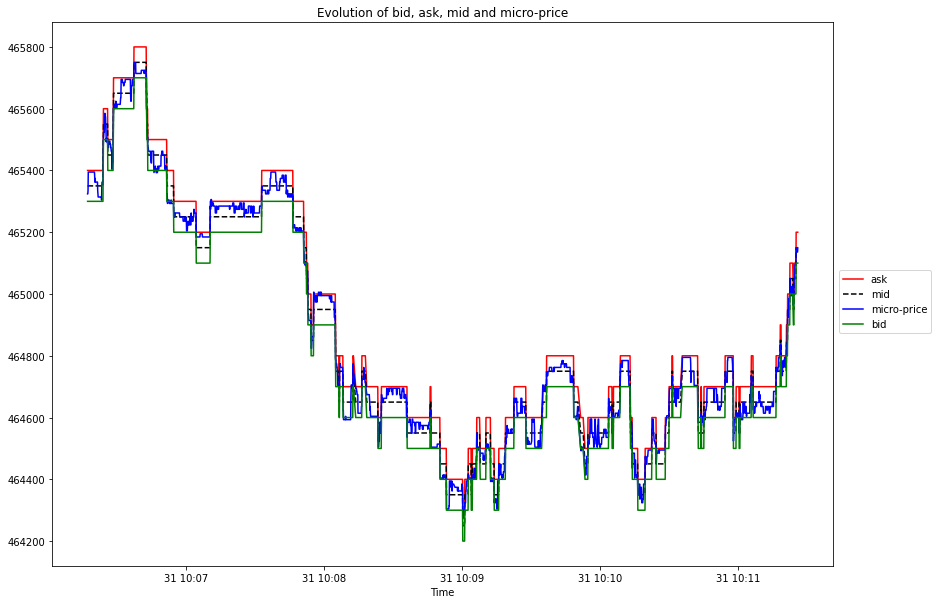

In [7]:
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(example_plot["ask_price_0"], "r")
ax.plot(example_plot["mid_price"], "k--")
ax.plot(example_plot["mid_price"] + example_plot["micro_price"], "b")
ax.plot(example_plot["bid_price_0"], "g")
ax.set_title("Evolution of bid, ask, mid and micro-price")
ax.set_xlabel("Time")
fig.legend(["ask", "mid", "micro-price", "bid"], loc="right")
plt.show()